# Bayesian Time Series Analysis of Spotify Listening Time per Day

## Set up 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import stan
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel

# Load the prepared data
spot = pd.read_csv('spot_day_data.csv')

spot = spot[['date', 'minutes_listened']]

## Model Specifications

Proceeding with a Bayesian Structural Time Series model. This model consists of four components: trend, seasonality, regression, and autoregression.

1. **Local level model**: Determines the central tendency of the series. It has one parameter: \( u_t \).
2. **Local linear trend**: Determines the trend of the series. It has two parameters: \( u_t \) (level) and \( v_t \) (slope, which is the rate of change of the level).
3. **Seasonal effect**: Determines the magnitude and pattern of the series. It has one parameter: \( s_t \).
4. **Regression effect**: Determines the effect of external variables on the series, more specifically the covariates. It has one parameter: \( B \).
5. **Autoregressive effect**: Determines the effect of the previous values of the series on the current value. It has one parameter: \( \phi \).
6. **Error term**: Determines the noise of the series. It has one parameter: \( \sigma \).

The model is defined by the following equation:

where:
- \( y_t \) is the observed value at time \( t \),  
- \( u_t \) is the local level at time \( t \), 
- \( v_t \) is the local linear trend at time \( t \),  
- \( s_t \) is the seasonal effect at time \( t \), 
- \( B \) is the regression effect of covariates \( x_t \), 
- \( \phi \) is the autoregressive effect,
- \( \epsilon_t \) is the error term.


## Prior Distrib and Prior Pred

$$
u_t \sim \mathcal{N}(0, 10),    
v_t \sim \mathcal{N}(0.5, 1),   
s_t \sim \mathcal{N}(0, 1),     
B \sim \mathcal{N}(0, 1),   
\phi \sim \mathcal{N}(0, 0.5^2),     
\sigma \sim \text{Inverse-Gamma}(2.1, 1.1)
$$

In [20]:
# Define the Stan model with prior predictive checks
stan_model_code_prior_predictive = """
data {
  int<lower=0> N; // number of observations
}

parameters {
  real mu; // level
  real beta; // slope
  real<lower=0> sigma; // observation noise
  real<lower=0> phi; // autoregressive coefficient
  real<lower=0> gamma; // seasonal effect
  real B; // regression coefficient
}

model {
  // Priors
  mu ~ normal(0, 10);
  beta ~ normal(0.5, 1);
  sigma ~ inv_gamma(2.1, 1.1);
  phi ~ normal(0, 0.5);
  gamma ~ normal(0, 1);
  B ~ normal(0, 1);
}

generated quantities {
  vector[N] y_sim;
  y_sim[1] = normal_rng(mu + B, sigma);
  for (n in 2:N) {
    y_sim[n] = normal_rng(mu + beta * n + phi * y_sim[n-1] + gamma * sin(2 * pi() * n / 365) + B, sigma);
  }
}
"""

# Save the model to a .stan file
with open('bsts_prior_predictive.stan', 'w') as file:
    file.write(stan_model_code_prior_predictive)

# prior pred 
model = CmdStanModel(stan_file='bsts_prior_predictive.stan')

# Prepare the data for Stan
data = {
    'N': len(spot),

}

# Sample from the prior predictive distribution
fit = model.sample(data=data, iter_sampling=8000, iter_warmup=1000, chains=4, fixed_param=True)

18:38:26 - cmdstanpy - INFO - compiling stan file /home/arrowboy/Documents/School/Spring2024/Stat415/project/bsts_prior_predictive.stan to exe file /home/arrowboy/Documents/School/Spring2024/Stat415/project/bsts_prior_predictive
18:38:37 - cmdstanpy - INFO - compiled model executable: /home/arrowboy/Documents/School/Spring2024/Stat415/project/bsts_prior_predictive
18:38:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▎         | 00:00 Iteration:  100 / 8000 [  1%]  (Sampling)
chain 1 |▌         | 00:00 Iteration:  300 / 8000 [  3%]  (Sampling)


chain 1 |▊         | 00:00 Iteration:  600 / 8000 [  7%]  (Sampling)


chain 1 |█▏        | 00:00 Iteration:  900 / 8000 [ 11%]  (Sampling)


chain 1 |█▌        | 00:00 Iteration: 1200 / 8000 [ 15%]  (Sampling)


chain 1 |█▊        | 00:00 Iteration: 1500 / 8000 [ 18%]  (Sampling)




chain 1 |██▏       | 00:00 Iteration: 1800 / 8000 [ 22%]  (Sampling)



chain 1 |██▌       | 00:01 Iteration: 210


18:38:40 - cmdstanpy - INFO - CmdStan done processing.


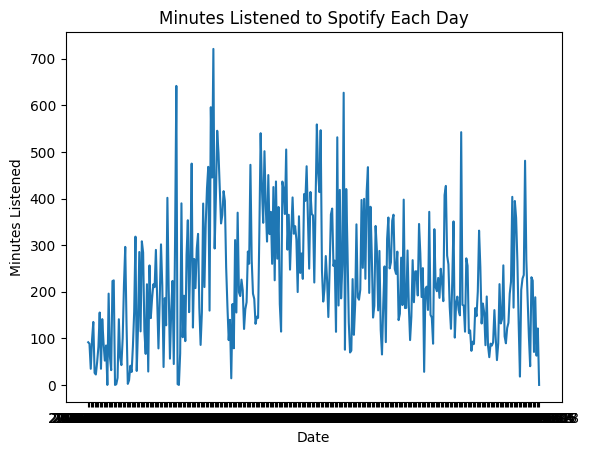

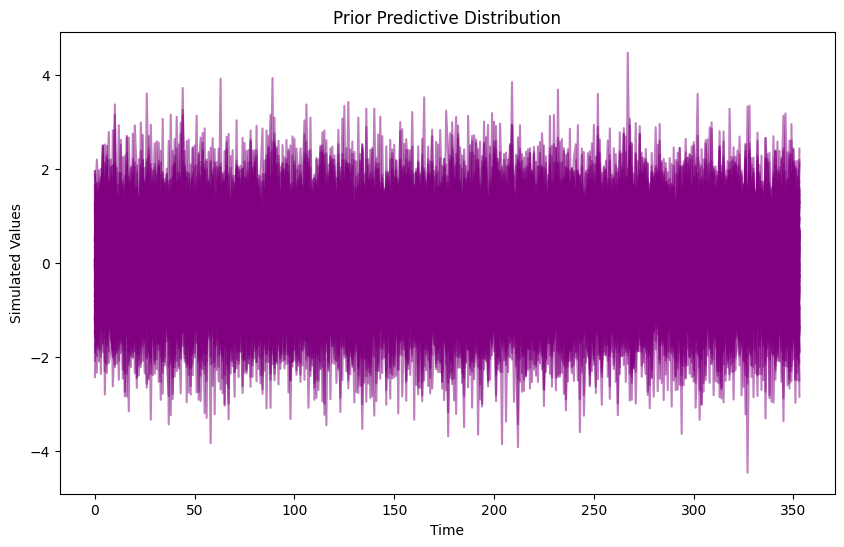

In [21]:
# plotting 
# putting pred plot and data plot together 
# getting the number of minutes listened to each day plot
plt.plot(spot['date'], spot['minutes_listened'])
plt.xlabel('Date')
plt.ylabel('Minutes Listened')
plt.title('Minutes Listened to Spotify Each Day')
plt.show()

# Extract the samples to plot
np.random.seed(42)
y_sim = pd.DataFrame(np.random.randn(100, len(spot)))

plt.figure(figsize=(10, 6))
for i in range(100):  # Plot 100 samples from the prior predictive distribution
    plt.plot(y_sim.iloc[i, :], color='purple', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Simulated Values')
plt.title('Prior Predictive Distribution')
plt.show()

The initial model seems VERYYYY wrong. We see values that are bouncing between 4 and -4, which is very inaccurate. We need to see only positive values and avg values way higher. The actual data has vals ranging from 0 to 700ish and an upside down U shape trend.

We need to restrict level(mu) to only be positive values.

Back to drawing board:

mu: vals need to be WAYYYY higher so making it centered around 350ish with wide sd 
beta: b/c the upside down U-shape to the sample data we want a slope that could be neg or pos, but dont know too much else
seasonal and reg: not too sure how to account for changing of data over time becuase upside down u means it will have both a + and - slope at some point, so making them centered at 0 so we could be both vals

# Adjusting Prior

In [35]:
updated_prior_stat_code = """
data {
  int<lower=0> N; // number of observations
}

parameters {
  real<lower=0> mu; // level
  real<lower=0> beta; // slope
  real<lower=0> sigma; // observation noise
  real<lower=0> phi; // autoregressive coefficient
  real<lower=0> gamma; // seasonal effect
  real B; // regression coefficient
}

model {
  // Priors
  mu ~ normal(350, 200); // Centered around the middle of the observed range
  beta ~ normal(0, 10); // Slope with a reasonable range
  sigma ~ inv_gamma(2.1, 1.1); // Keeping this the same
  phi ~ normal(0, 0.5); // Keeping this the same
  gamma ~ normal(0, 10); // Seasonal effect with a reasonable range
  B ~ normal(0, 10); // Regression coefficient with a reasonable range
}

generated quantities {
  vector[N] y_sim;
  y_sim[1] = normal_rng(mu + B, sigma); // First value for start of train
  for (n in 2:N) {
    y_sim[n] = normal_rng(mu + beta * n + phi * y_sim[n-1] + gamma * sin(2 * pi() * n / 365) + B, sigma);
  }
}
"""

# Save the model to a .stan file
with open('bsts_updated_prior_predictive.stan', 'w') as file:
    file.write(updated_prior_stat_code)

# prior pred
model2 = CmdStanModel(stan_file='bsts_updated_prior_predictive.stan')

fit2 = model2.sample(data=data, iter_sampling=4000, chains=4, fixed_param=True) # fixing params bc we dont want them to change in prior pred

19:22:30 - cmdstanpy - INFO - compiling stan file /home/arrowboy/Documents/School/Spring2024/Stat415/project/bsts_updated_prior_predictive.stan to exe file /home/arrowboy/Documents/School/Spring2024/Stat415/project/bsts_updated_prior_predictive
19:22:41 - cmdstanpy - INFO - compiled model executable: /home/arrowboy/Documents/School/Spring2024/Stat415/project/bsts_updated_prior_predictive
19:22:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▊         | 00:00 Iteration:  200 / 4000 [  5%]  (Sampling)


chain 1 |█▌        | 00:00 Iteration:  600 / 4000 [ 15%]  (Sampling)


chain 1 |██▎       | 00:00 Iteration: 1000 / 4000 [ 25%]  (Sampling)


chain 1 |███       | 00:00 Iteration: 1400 / 4000 [ 35%]  (Sampling)


chain 1 |███▊      | 00:00 Iteration: 1800 / 4000 [ 45%]  (Sampling)


chain 1 |████▌     | 00:00 Iteration: 2200 / 4000 [ 55%]  (Sampling)


chain 1 |█████▍    | 00:00 Iteration: 2600 / 4000 [ 65%]  (Sampling)


chain 1 |██████▏   | 


19:22:42 - cmdstanpy - INFO - CmdStan done processing.


19:22:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Iteration: 1001 / 5000 [ 20%]  (Sampling)





chain 1 |████▊     | 00:00 Iteration: 2200 / 5000 [ 44%]  (Sampling)


chain 1 |█████▉    | 00:00 Iteration: 2800 / 5000 [ 56%]  (Sampling)


chain 1 |██████▉   | 00:01 Iteration: 3300 / 5000 [ 66%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 3700 / 5000 [ 74%]  (Sampling)


chain 1 |████████▍ | 00:01 Iteration: 4100 / 5000 [ 82%]  (Sampling)


chain 1 |█████████▏| 00:01 Iteration: 4500 / 5000 [ 90%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


19:22:44 - cmdstanpy - INFO - CmdStan done processing.


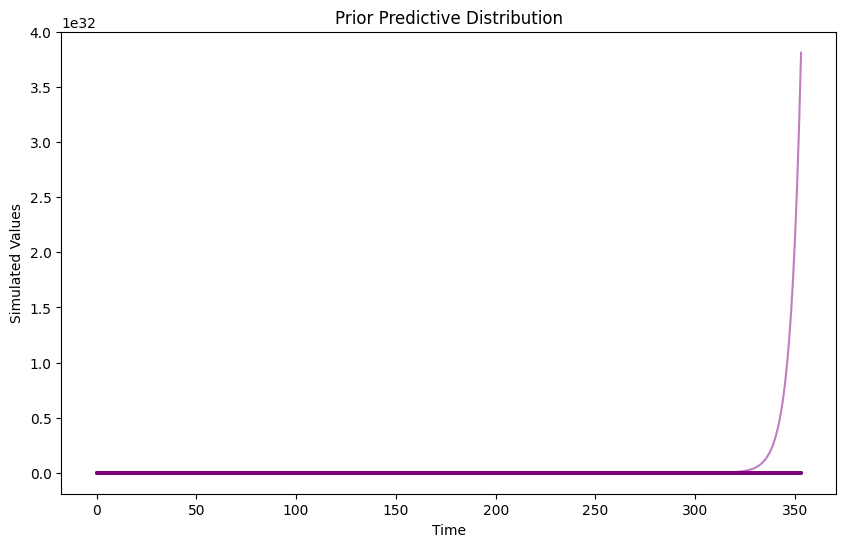

In [36]:
# Sample from the prior distribution
prior_samples = model2.sample(data=data, iter_sampling=4000, chains=4)

prior_samples = prior_samples.stan_variable('y_sim')
prior_samples = pd.DataFrame(prior_samples)


# Plot the prior predictive samples
plt.figure(figsize=(10, 6))


for i in range(100):  # Plot 100 samples from the prior predictive distribution
    plt.plot(prior_samples.iloc[i, :], color='purple', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Simulated Values')
plt.title('Prior Predictive Distribution')
plt.show()

Wellll that really didnt work.... we are going to proceed with posterior sampling and just let stan pick some param distribs we are unsure about. 

We are pretty confident about mu, so we prob gonna keep that the same

letting stan pick beta, phi, and gamma distribs


# Posterior Calculation

In [58]:
# Save the modified model to a .stan file
stan_model_code = """
data {
  int<lower=0> N; // number of observations
  vector[N] y; // observed data
}

parameters {
  real mu; // level
  real beta; // slope
  real<lower=0> sigma; // observation noise
  real<lower=0, upper=1> phi; // autoregressive coefficient
  real gamma; // seasonal effect
  real B; // regression coefficient
}


model {
  // Priors
  mu ~ normal(350, 100); // Centered around the middle of the observed range
  // beta ~ normal(0, 10); // Slope with a reasonable range
  sigma ~ normal(120, 20); // Keeping this the same
  phi ~ beta(2, 2); // Keeping this the same
  // gamma ~ normal(0, 10); // Seasonal effect with a reasonable range
  // B ~ normal(0, 10); // Regression coefficient with a reasonable range

  // Likelihood
  for (n in 2:N) {
    y[n] ~ normal(mu + beta * n + phi * y[n-1] + gamma * sin(2 * pi() * n / 365) + B, sigma);
  }
}

generated quantities {
  vector[N] y_sim;
  y_sim[1] = normal_rng(mu, sigma); // Initial value
  for (n in 2:N) {
    y_sim[n] = normal_rng(mu + beta * n + phi * y_sim[n-1] + gamma * sin(2 * pi() * n / 365) + B, sigma);
  }
}
"""

# Save the Stan model to a file
with open('bsts_model_post.stan', 'w') as file:
    file.write(stan_model_code)

# Compile the Stan model
model = CmdStanModel(stan_file='bsts_model_post.stan')

21:55:42 - cmdstanpy - INFO - compiling stan file /home/arrowboy/Documents/School/Spring2024/Stat415/project/bsts_model_post.stan to exe file /home/arrowboy/Documents/School/Spring2024/Stat415/project/bsts_model_post
21:55:52 - cmdstanpy - INFO - compiled model executable: /home/arrowboy/Documents/School/Spring2024/Stat415/project/bsts_model_post


In [65]:
# Plot the posterior predictive distribution
data = {
    'N': len(spot),
    'y': spot['minutes_listened'].values
}

# Fit the model to the data
fit = model.sample(data=data, iter_sampling=3000, iter_warmup=1000, chains=1)



22:01:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status

chain 1 |██████████| 00:19 Sampling completed                       


22:01:55 - cmdstanpy - INFO - CmdStan done processing.


<Figure size 1000x600 with 0 Axes>

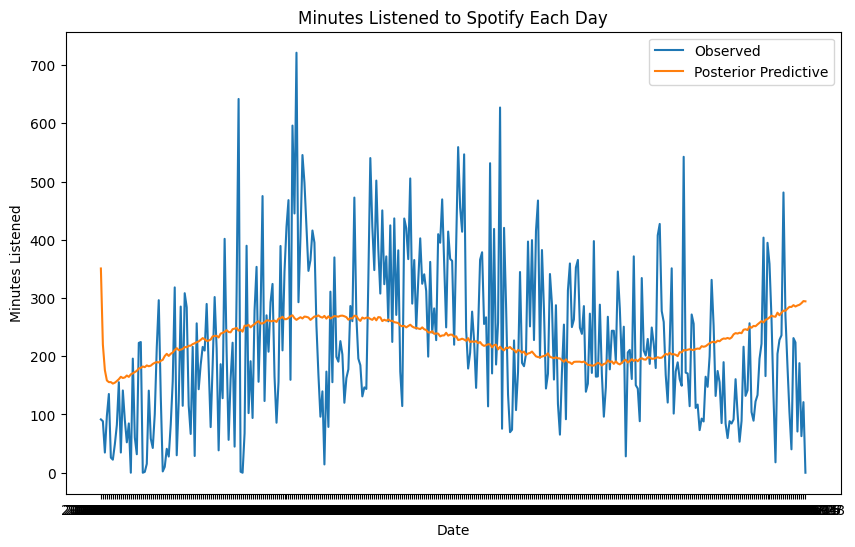

In [67]:
# Print the results
res = fit.summary()
res_df = pd.DataFrame(res)
res_df

# Extract the samples from dataframe res_df
# remove first 5 rows
posterior_samples = res_df.iloc[7:, :]
# keep only mean col
posterior_samples = posterior_samples['Mean']

# Plot the posterior sample mean values vs x
plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
plt.plot(spot['date'], spot['minutes_listened'], label='Observed')
plt.plot(spot['date'], posterior_samples, label='Posterior Predictive')
plt.xlabel('Date')
plt.ylabel('Minutes Listened')
plt.title('Minutes Listened to Spotify Each Day')
plt.legend()
plt.show()

## Posterior Predict

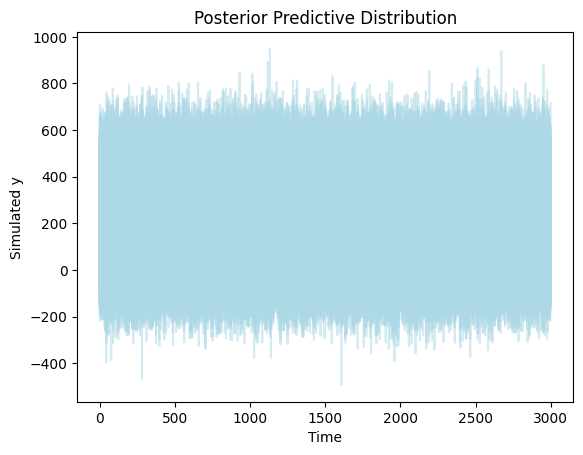

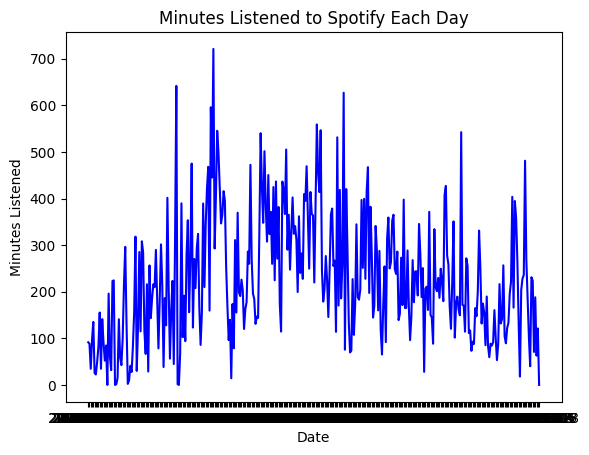

In [60]:
# Extract the posterior samples
posterior_samples = fit.draws_pd()

# Plot the posterior predictive distribution
for col in posterior_samples.columns:
    if 'y_sim' in col:
        plt.plot(posterior_samples[col], color='lightblue', alpha=0.5)

plt.xlabel('Time')
plt.ylabel('Simulated y')
plt.title('Posterior Predictive Distribution')
plt.show()

# Plot the observed data for comparison
plt.plot(spot['date'], spot['minutes_listened'], color='blue')
plt.xlabel('Date')
plt.ylabel('Minutes Listened')
plt.title('Minutes Listened to Spotify Each Day')
plt.show()